In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests

START_DATE = '2017-01-01'
END_DATE = '2019-01-01'

In [44]:
def make_frame(content):
    prices = {}
    for line in content.split('\n'):
        if '{' in line or '}' in line:
            continue
        data = (
            line
            .lstrip().lstrip("'")
            .rstrip().rstrip("',")
            .split(':')
        )
        if len(data) < 3:
            data.append(np.nan)
        secs, price, volume = data
        prices[int(secs)] = (int(price), float(volume))
        
    price_frame = pd.DataFrame(prices, index = ['price', 'volume']).T
    price_frame.index = pd.to_datetime(price_frame.index, unit = 's')
    
    return price_frame

def fetch_from_wiki(item_name):
    # Totally lifted from:
    # https://github.com/osrsbox/osrsbox.github.io/blob/master/_posts/2018-12-14-scraping-the-osrs-wiki-part3.md
    
    # Construction custom user-agent for query
    custom_agent = {
        'User-Agent': 'CSCE421Scraper',
        'From': 'presley.graham@tamu.edu' 
    }
    
    page_title = f'Module:Exchange/{item_name}/Data'

    # Construct the para.meters of the API query
    parameters = {
        'action': 'parse',
        'prop': 'wikitext',
        'format': 'json',
        'page': page_title,
    }

    # Call the API using the custom user-agent and parameters
    result = requests.get('https://oldschool.runescape.wiki/api.php', 
                            headers=custom_agent, 
                            params=parameters).json()
    
    content = result['parse']['wikitext']['*']
    return make_frame(content)

In [45]:
def item_filename(item_name):
    return os.path.join('data', f'{item_name}.csv')

def fetch_from_disk(item_name):
    file_name = item_filename(item_name)
    
    # First, check to make sure the item is actually on disk
    if not os.path.isfile(file_name):
        return None
    
    # Read in the price frame; manually set index to first line
    price_frame = pd.read_csv(file_name).set_index('Unnamed: 0')
    
    display(price_frame)
    
    # Get rid of the ugly index name
    price_frame.index.name = None
    
    return price_frame

In [46]:
from functools import lru_cache

# fetch(item_name) returns 
@lru_cache(maxsize = None)
def fetch(item_name):
    # check if we have the item data on disk
    # TODO: check if the data is too old
    price_frame = None #fetch_from_disk(item_name)
    if price_frame is not None:
        return price_frame
    
    # if not, fetch it from the wiki
    price_frame = fetch_from_wiki(item_name)
    # and dump it to a file
    price_frame.to_csv(item_filename(item_name))
    return price_frame

In [47]:
# make mean 0
def demean(series):
    return series - series.mean()

def remove_outliers(series, sigma = 3):
    mean, std_dev = series.mean(), series.std()
    min_value = mean - sigma * std_dev
    max_value = mean + sigma * std_dev
    return series[(min_value <= series) & (series <= max_value)]

# half-open interval, like range()
def limit_to_dates(series, start_on = '1980-01-01', end_before = '3000-01-01'):
    start_date = pd.to_datetime(start_on)
    end_date = pd.to_datetime(end_before)
    return series[(start_date <= series.index) & (series.index < end_date)]

In [48]:
def prices(item_name):
    price = fetch(item_name)['price'].dropna()
    return price

def returns(item_name, lookback = 2):
    price = prices(item_name)
    return ((price - price.shift(lookback)) / price).dropna()

def gold_traded(item_name):
    prices = fetch(item_name)['price'] 
    volumes = fetch(item_name)['volume']
    return (prices * volumes).dropna()

In [49]:
def clean_returns(item_name):
    raw_returns = returns(item_name, lookback = 2)
    # set to zero mean and remove crazy outliers
    cleaned_returns = remove_outliers(demean(raw_returns), sigma = 4)
    # keep 2019 and beyond pristine
    cleaned_returns = limit_to_dates(cleaned_returns, start_on = START_DATE, end_before = END_DATE)
    return cleaned_returns

def clean_prices(item_name):
    raw_prices = prices(item_name)
    cleaned_prices = limit_to_dates(raw_prices, start_on = START_DATE, end_before = END_DATE)
    return cleaned_prices

def percent_prices(item_name):
    price = clean_prices(item_name)
    return price / price.mean()

In [50]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def to_2d_array(df):
    if type(df) is pd.Series:
        return df.values.reshape(-1, 1)
    elif type(df) is pd.DataFrame:
        return df.values
    else:
        return df

def common_index(*series):
    common_index = series[0].index
    for serie in series[1:]:
        common_index &= serie.index
    return common_index

def svm_dataset(pred_names, resp_name, threshold = 0.05):
    if type(pred_names) is not list:
        pred_names = [pred_names]
    
    resp = (clean_returns(resp_name).shift(-7) > threshold).rename(resp_name)
    pred_list = [clean_returns(pred_name).rename(pred_name) for pred_name in pred_names]

    index = common_index(resp, *pred_list)
    
    pred = pd.concat(pred_list, axis = 1).reindex(index)
    resp = resp.reindex(index)
    
    X = to_2d_array(pred)
    y = to_2d_array(resp)
    
    return X, y

In [51]:
def beta(pred_names, resp_name, plot = False, func = clean_returns):
    if type(pred_names) is not list:
        pred_names = [pred_names]
    
    resp = func(resp_name).rename(resp_name)
    pred_list = [func(pred_name).rename(pred_name) for pred_name in pred_names]

    index = common_index(resp, *pred_list)
    
    pred = pd.concat(pred_list, axis = 1).reindex(index)
    resp = resp.reindex(index)
    
    X = to_2d_array(pred)
    y = to_2d_array(resp)
    
    X, y = get_X_and_y(pred_names, resp_name, pred_func = func, resp_func = func)
    
    model = LinearRegression(fit_intercept = True)
    model.fit(X, y)
    
    if plot:
        assert len(pred_names) == 1, "can only make 2D plots with 1 predictor and 1 response"
        sns.regplot(pred, resp)
    
    betas = list(model.coef_[0])
    r2 = r2_score(y_true = y, y_pred = model.predict(X))
    if len(betas) == 1:
        betas = betas[0]
    return betas, r2

def plot_over_time(*item_names, func = clean_prices):
    frame = pd.concat([func(item_name).rename(item_name) for item_name in item_names], axis = 1)
    frame.plot()

(0.9906905203633053, 0.9048434979695132)

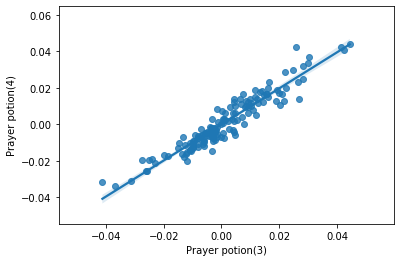

In [52]:
func_to_plot = lambda item_name : limit_to_dates(returns(item_name), '2018-08-01', '2019-01-01')
beta('Prayer potion(3)', 'Prayer potion(4)', func = func_to_plot, plot = True)

(1.3379598505394754, 0.9551224195805869)

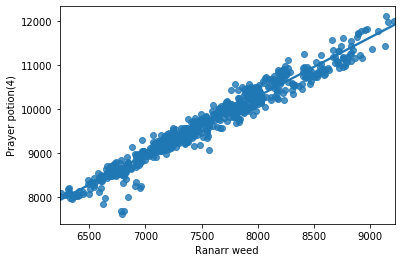

In [53]:
beta('Ranarr weed', 'Prayer potion(4)', func = clean_prices, plot = True)

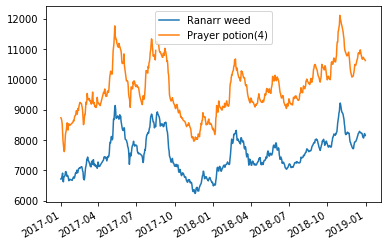

In [54]:
plot_over_time('Ranarr weed', 'Prayer potion(4)', func = clean_prices)

In [55]:
# TODO:
# - refresh old data on disk

In [57]:
svm_dataset("Ranarr weed", "Prayer potion(4)")

(array([[-1.17318523e-02],
        [-6.51220540e-03],
        [ 7.28225376e-03],
        [ 1.49880169e-02],
        [ 2.01521268e-02],
        [-4.37569220e-02],
        [ 2.05338300e-02],
        [ 2.44823138e-02],
        [ 3.55769936e-03],
        [ 6.90054536e-03],
        [ 1.98742102e-02],
        [ 1.62606717e-02],
        [-5.90596588e-03],
        [-2.28877405e-02],
        [-1.32980235e-02],
        [ 2.95940415e-03],
        [-4.08236043e-03],
        [-1.46599245e-02],
        [-2.27934232e-02],
        [-1.07539951e-02],
        [ 6.45832692e-03],
        [ 4.37086806e-03],
        [-5.95504513e-03],
        [ 2.27329668e-03],
        [ 9.24941649e-03],
        [ 8.29635788e-03],
        [ 6.08560117e-03],
        [-6.49010383e-03],
        [-5.54505075e-04],
        [ 1.47874002e-02],
        [ 1.85510095e-02],
        [ 1.02852116e-02],
        [-1.42369238e-03],
        [ 1.12992510e-02],
        [ 5.77916414e-03],
        [-1.29894386e-02],
        [ 2.02984525e-03],
 